In [1]:
from __future__ import print_function
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import torch
import utils
from utils import set_default_device, init_logger, get_currenttime_prefix, save_checkpoint
from project_utils import init_data_loaders_rl_training, init_model_rl_training, train, test

In [2]:
class options:
    def __init__(self):
        self.seed = 42
        self.use_cpu = False
        self.evaluate = False
        self.save_dir = ''
        self.dataset = 'prid'
        self.arch = 'alexnet'
        self.height = 224
        self.width = 112
        self.seq_len = 8
        self.seq_len_rl = 8
        self.lr = 0.001
        self.weight_decay = 5e-4
        self.rp = 0.2
        self.train_batch = 1
        self.workers = 0
        self.test_batch = 1
        self.prefix = 'analysis'
        self.gpu_devices = '0'
        self.rl_algo = 'ql'
        self.pretrained_model = None
        self.pretrained_model_rl = '../scratch/25-Nov-2018_19:07:45_multishot-rl/rl_0.2_checkpoint_ep700.pth.tar'
    
args = options()

In [370]:
# set the seed for reproducibility
torch.manual_seed(args.seed)
use_gpu = set_default_device(args)

# append date with save_dir
args.save_dir = '../scratch/' + get_currenttime_prefix() + '_' + args.save_dir
if args.pretrained_model is not None:
    args.save_dir = os.path.dirname(args.pretrained_model)

# # init the logger
# init_logger(args)

# data loading
dataset, trainloader, queryloader, galleryloader = init_data_loaders_rl_training(args, test_shuffle=False)
num_train_pids = dataset.num_train_pids

# init model
model = init_model_rl_training(args, num_train_pids)


Currently using GPU 0
Initializing dataset prid
# train identites: 89, # test identites 89
=> PRID-2011 loaded
Dataset statistics:
  ------------------------------
  subset   | # ids | # tracklets
  ------------------------------
  train    |    89 |      178
  query    |    89 |       89
  gallery  |    89 |       89
  ------------------------------
  total    |   178 |      356
  number of images per tracklet: 28 ~ 675, average 108.1
  ------------------------------
these IDs are removed from training []
In total  89  persons
Initializing model: alexnet
creating agent for Q learning
Loading checkpoint from '../scratch/25-Nov-2018_19:07:45_multishot-rl/rl_0.2_checkpoint_ep700.pth.tar'
16  keys in pretrained model
16  keys in current model
16  keys in pretrained model are available in current model


In [371]:
def show_imgs(imgs, filename):
    imgs = imgs.clone()
    imgs[:, 0, :, :] = imgs[:, 0, :, :].clone() * 0.229 + 0.485
    imgs[:, 1, :, :] = imgs[:, 1, :, :].clone() * 0.224 + 0.456
    imgs[:, 2, :, :] = imgs[:, 2, :, :].clone() * 0.225 + 0.406    
    grid = make_grid(imgs)
    fig = plt.figure()
    plt.imshow(grid.permute(1,2,0).cpu().numpy())
    plt.xticks([])
    plt.yticks([])
    plt.show()
    save_image(grid, filename)

In [402]:
model.brain.eval().cuda()
model.feature_extractor.eval().cuda()

query_iter = iter(queryloader)
gallery_iter = iter(galleryloader)
query_imgs, query_pid, _ = query_iter.next()
query_imgs = query_imgs.cuda()[0]

torch.Size([142, 1, 3, 224, 112]) torch.Size([83, 1, 3, 224, 112])
torch.Size([142, 256]) torch.Size([83, 256])
2
torch.Size([142, 1, 3, 224, 112]) torch.Size([83, 1, 3, 224, 112])
torch.Size([2, 3, 224, 112]) torch.Size([2, 3, 224, 112])
pids tensor([0]) tensor([0])
actions
2
0


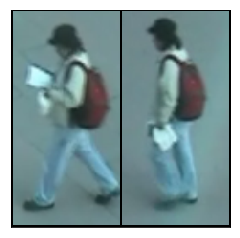

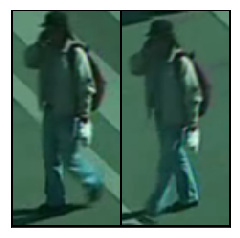

In [403]:

gallery_imgs, gallery_pid, _ = gallery_iter.next()

gallery_imgs = gallery_imgs.cuda()[0]
print(query_imgs.shape, gallery_imgs.shape)

_, query_features = model.feature_extractor(query_imgs)
_, gallery_features = model.feature_extractor(gallery_imgs)
query_features = query_features.squeeze(1)
gallery_features = gallery_features.squeeze(1)

from models.RL_model import Environment

print(query_features.shape, gallery_features.shape)
min_frames = min(query_features.shape[0], gallery_features.shape[0])
query_features = model.select_random_features(query_features, min_frames)
gallery_features = model.select_random_features(gallery_features, min_frames)

model.env = Environment({'features': query_features, 'id':query_pid},
                        {'features': gallery_features, 'id':gallery_pid}, args.rp)

samples, total_reward, iters, q_values = model.play_one_episode(True)

from torchvision.utils import make_grid, save_image
total_comparisons = len(samples)
print(total_comparisons)
print(query_imgs.shape, gallery_imgs.shape)
query_needed_imgs = query_imgs[:total_comparisons].squeeze(1)
gallery_needed_imgs = gallery_imgs[:total_comparisons].squeeze(1)
print(query_needed_imgs.shape, gallery_needed_imgs.shape)
print('pids', query_pid, gallery_pid)
print('actions')
for s in samples:
    print(s[1])
show_imgs(query_needed_imgs, 'query.png')
show_imgs(gallery_needed_imgs, 'gallery.png')